# This notebook contains the code and figures for the data from measuring display latencies

What data do we have?

    A. Light intensity over time
    B. (A) for multiple trials
    C. (B) for different frame rate (FR), resolution, and modes
    D. (C) for different monitor/projector

What information to extract?

    A. How light is being shone by the monitor/projector in every trial
    B. How does the latency changes over time
    C. Distribution of light intensity for the whole experiment - histogram of (A)
    D. Distribution of latencies for the whole experiment
    E. (A, B, C, and D) across different FR, resolution, modes
    F. (A, B, C, and D) across different monitors (For the same FR, resolution, modes)
    G. Mean latency versus FR across across different monitors
    H. Mean latency versus Resolution across different monitors
    
Related to our device: 

    I. What is the sampling frequency of our device

---

In [1]:
# %load_ext autoreload
# %autoreload 2

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
import seaborn as sns
import os
import glob
from tqdm import tqdm
from matplotlib import cm, colors

import vrlatency as vrl

## Import Data

In [2]:
path_data = "../../data/"
path_fig = "../../Figures/display/"

os.chdir(path_data)

In [3]:
df_data_all = pd.DataFrame()
df_params_all = pd.DataFrame()

for filename in tqdm(glob.glob('*.csv')):
    name = filename.split('.')[0]
    
    df_data = vrl.read_csv(filename)
    df_data['Session'] = name
    params = vrl.read_params(filename)
    params_series = pd.Series(params)
    params_series.name = name
    
    df_data_all = df_data_all.append(df_data)
    df_params_all = df_params_all.append(params_series)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:11<00:00,  2.35it/s]


In [4]:
df_params_all.head()

,Date,Depth,Experiment,Height,Monitors,Rate,Time,Trials,Width
display_20180830_115317,30.08.2018,32,DisplayExperiment,1080,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,11:51:10,1000,1920
display_20180830_123133,30.08.2018,32,DisplayExperiment,1080,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,120,12:29:25,1000,1920
display_20180830_123445,30.08.2018,32,DisplayExperiment,1024,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,12:32:37,1000,1280
display_20180830_124007,30.08.2018,32,DisplayExperiment,720,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,12:37:59,1000,1280
display_20180830_124242,30.08.2018,32,DisplayExperiment,768,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,12:40:34,1000,1024


## Fix Params dataframe dtypes

In [5]:
dfp = df_params_all.copy()
int_params = ['Width', 'Height', 'Depth', 'Rate', 'Trials']
dfp[int_params] = df_params_all[int_params].astype(int)
dfp['Timestamp'] = pd.to_datetime(df_params_all.Date.str.cat(df_params_all.Time, sep=' '), format="%d.%m.%Y %H:%M:%S")
del dfp['Time']
del dfp['Date']
dfp.head().dtypes

Depth                  int32
Experiment            object
Height                 int32
Monitors              object
Rate                   int32
Trials                 int32
Width                  int32
Timestamp     datetime64[ns]
dtype: object

## Data Transformation

In [6]:
dfp['Pixels'] = dfp['Height'] * dfp['Width']
dfp.head(3)

,Depth,Experiment,Height,Monitors,Rate,Trials,Width,Timestamp,Pixels
display_20180830_115317,32,DisplayExperiment,1080,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,1000,1920,2018-08-30 11:51:10,2073600
display_20180830_123133,32,DisplayExperiment,1080,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,120,1000,1920,2018-08-30 12:29:25,2073600
display_20180830_123445,32,DisplayExperiment,1024,SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009,60,1000,1280,2018-08-30 12:32:37,1310720


In [7]:
df= df_data_all.copy()
df['Time'] = df['Time'] / 1000
trials = df.groupby(['Session', 'Trial'])
df['TrialTime'] = trials.Time.apply(lambda x: x - x.min())
df['Sample'] = trials.cumcount()
df['Session'] = pd.Categorical(df['Session'])
df.head()

,Trial,Time,SensorBrightness,Session,TrialTime,Sample
0,2,813.068,0,display_20180830_115317,0.000,0
1,2,813.340,0,display_20180830_115317,0.272,1
2,2,813.612,0,display_20180830_115317,0.544,2
3,2,813.884,0,display_20180830_115317,0.816,3
4,2,814.156,0,display_20180830_115317,1.088,4


In [8]:
df = df.reindex(['Session', 'Trial', 'Sample', 'Time', 'TrialTime', 'SensorBrightness'], axis=1)
df.head()

,Session,Trial,Sample,Time,TrialTime,SensorBrightness
0,display_20180830_115317,2,0,813.068,0.000,0
1,display_20180830_115317,2,1,813.340,0.272,0
2,display_20180830_115317,2,2,813.612,0.544,0
3,display_20180830_115317,2,3,813.884,0.816,0
4,display_20180830_115317,2,4,814.156,1.088,0


Time to beat:

In [9]:
# %timeit vrl.get_display_latencies(dd)

current time:

In [10]:
# %load_ext line_profiler

In [11]:
# %timeit vrl.get_display_latencies(dd)

In [12]:
# %lprun -f vrl.get_display_latencies vrl.get_display_latencies(dd)

In [13]:
thresh=.75
latencies = df.groupby('Session').apply(vrl.get_display_latencies, thresh=thresh).reset_index()
# latencies.name = 'DisplayLatency'
# latencies = latencies.reset_index()
latencies.head()

,Session,Trial,DisplayLatency
0,display_20180830_115317,2,38.488
1,display_20180830_115317,3,29.504
2,display_20180830_115317,4,28.664
3,display_20180830_115317,5,19.376
4,display_20180830_115317,6,34.672


In [14]:
dfl = pd.merge(df, latencies, on=['Session', 'Trial'])
dfl['TrialTransitionTime'] = dfl['TrialTime'] - dfl['DisplayLatency']
dfl.head()

,Session,Trial,Sample,Time,TrialTime,SensorBrightness,DisplayLatency,TrialTransitionTime
0,display_20180830_115317,2,0,813.068,0.000,0,38.488,-38.488
1,display_20180830_115317,2,1,813.340,0.272,0,38.488,-38.216
2,display_20180830_115317,2,2,813.612,0.544,0,38.488,-37.944
3,display_20180830_115317,2,3,813.884,0.816,0,38.488,-37.672
4,display_20180830_115317,2,4,814.156,1.088,0,38.488,-37.400


---

## Session Analysis

In [ ]:
sess_id = 16  # Choose the session
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session].copy()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)

s2 = dd[dd.DisplayLatency == dd.DisplayLatency.min()].SensorBrightness.values

for trialnum in range(dd.Trial.min(), dd.Trial.max(), 20):
    s1 = dd[dd.Trial==trialnum].SensorBrightness.values

    ax1.plot(s1)
    ax1.plot(s2)

    offsets = 100    
    s1_mat = np.ndarray(buffer=s1, shape=(len(s1)-offsets, offsets), strides=(8, 8), dtype=s1.dtype)
    residuals = np.sum((s1_mat.T - s2[:-offsets]) ** 2, axis=1)

    ax2.plot(residuals)

    sampling_rate = np.diff(dd.TrialTime.values[:2])[0]
    ax3.plot(s1[np.argmin(residuals):])
    ax3.plot(s2)

c:\users\mohammad bashiri\anaconda3\envs\vrlatency3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


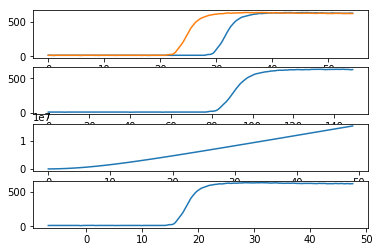

In [80]:
sess_id = 25  # Choose the session
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session].copy()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)

ref_trial = dd[dd.DisplayLatency == dd.DisplayLatency.max()]
s2 = ref_trial.SensorBrightness.values

# for trialnum in range(dd.Trial.min(), dd.Trial.max(), 20):

trialnum = 10
trial1 = dd[dd.Trial==trialnum]
s1 = trial1.SensorBrightness.values

ax1.plot(ref_trial.TrialTime, ref_trial.SensorBrightness)
ax1.plot(trial1.TrialTime, trial1.SensorBrightness)

offsets = 50    
s1_mat = np.ndarray(buffer=s1, shape=(len(s1)-offsets, offsets), strides=(8, 8), dtype=s1.dtype)
residuals = np.sum((s1_mat.T - s2[offsets//2:-offsets//2]) ** 2, axis=1)

ax2.plot(s2[offsets//2:-offsets//2])

ax3.plot(residuals)

sampling_rate = np.diff(dd.TrialTime.values[:2])[0]   
trial1['TrialTransitionTime'] = dd['TrialTime'] - (np.argmin(residuals)  + offsets//2)  * sampling_rate
ax4.plot(trial1.TrialTransitionTime.values, trial1.SensorBrightness.values)

In [15]:
def shift_by_cross_corr(x1, x2, win=100):
    x1_mat = np.ndarray(buffer=x1, shape=(len(x1)-win, win), strides=(8, 8), dtype=x1.dtype)  # Rolling backwards
    return np.sum((x1_mat.T - x2[win//2:-win//2]) ** 2, axis=1)

In [16]:
def find_global_minimum(x):
    dx, ddx = np.diff(x), np.diff(x, 2)
    is_zerocrossing = (dx[1:] * dx[:-1]) < 0
    is_positive_slope = ddx > 0
    is_local_minimum = is_zerocrossing & is_positive_slope

    local_minimum_indices = np.where(is_local_minimum)[0] + 1
    global_minimum_indices = local_minimum_indices[np.argmin(x[local_minimum_indices])]
    global_minimum_index = int(global_minimum_indices)
    return global_minimum_index

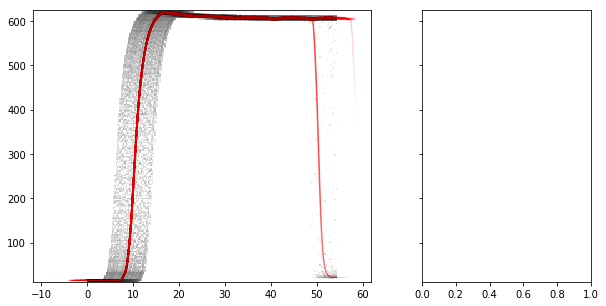

In [60]:
sess_id = 27  # Choose the session
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session].copy()

sampling_rate = np.diff(dd.TrialTime.values[:2])[0]

query = '(-5 < TrialTransitionTime) & (TrialTransitionTime < 5)'
dd2 = dd.query(query)

ref_trial = dd2[dd2.DisplayLatency == dd2.DisplayLatency.min()]  # Min latency used as reference
ref_sensor = ref_trial['SensorBrightness'].values

winsize = 30
for trialnum, trial in dd2.groupby('Trial'):
    test_sensor = trial['SensorBrightness'].values
    residuals = shift_by_cross_corr(test_sensor, ref_sensor, win=winsize)
    minimum = find_global_minimum(residuals) 
    offset = minimum - winsize//2
    dd.loc[dd.Trial == trialnum, 'TrialTransitionTime']  -= offset * sampling_rate


fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw = {'width_ratios': [2, 1]}, sharey=True)
ax1, ax2 = axes

# plot the brightness values for all the trials
# ax1.scatter(dd.TrialTime, dd.SensorBrightness, c='.3', s=.2, alpha=.2);
# ax1.scatter(dd.TrialTransitionTime + dd.groupby('Trial').DisplayLatency.mean().mean(), 
#             dd.SensorBrightness, c='r', s=.1, alpha=.1)

nsamples_per_trial = dd.groupby('Trial')['DisplayLatency'].agg(len).min()
H, xedges, yedges = np.histogram2d(dd.TrialTime, dd.SensorBrightness, bins=(nsamples_per_trial, 200))
H = H.T
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

ax1.imshow(H, interpolation='nearest', origin='low', cmap=my_cmap, aspect='auto', 
           extent=extent, norm=colors.LogNorm())
mean_latency = dd.groupby('Trial').DisplayLatency.mean().mean()
for trialnum, trial in dd.groupby('Trial'):
    ax1.plot(trial.TrialTransitionTime + mean_latency, trial.SensorBrightness, c=color, linewidth=1, alpha=.01)

# ax1.hlines([vrl.perc_range(dd['SensorBrightness'], thresh)], *ax1.get_xlim(), 'b', label='Threshold', linewidth=2, linestyle='dotted');

# sns.distplot(dd['SensorBrightness'].values, ax=ax2, vertical=True, hist_kws={'color': 'k'}, kde_kws={'alpha': 0})
# ax2.set(xticklabels='')
# ax1.set(xlabel='Trial Time', ylabel='Time from trial onset (ms)')
# fig.suptitle(session, y=1.02)
# fig.tight_layout(w_pad=0)
# fig;

----

In [ ]:
my_cmap = plt.cm.gray_r
my_cmap.set_bad(color='w')

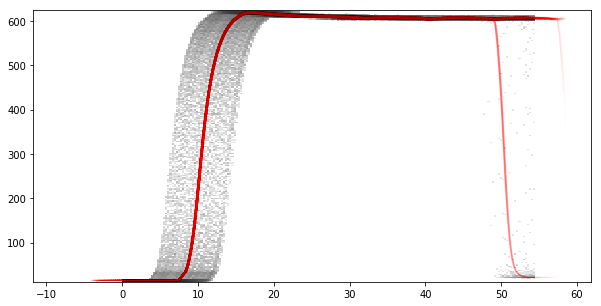

In [59]:
sess_id = 27  # Choose the session
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session].copy()

sampling_rate = np.diff(dd.TrialTime.values[:2])[0]

query = '(-5 < TrialTransitionTime) & (TrialTransitionTime < 5)'
dd2 = dd.query(query)

ref_trial = dd2[dd2.DisplayLatency == dd2.DisplayLatency.min()]  # Min latency used as reference
ref_sensor = ref_trial['SensorBrightness'].values

winsize = 30
for trialnum, trial in dd2.groupby('Trial'):
    test_sensor = trial['SensorBrightness'].values
    residuals = shift_by_cross_corr(test_sensor, ref_sensor, win=winsize)
    minimum = find_global_minimum(residuals) 
    offset = minimum - winsize//2
    dd.loc[dd.Trial == trialnum, 'TrialTransitionTime']  -= offset * sampling_rate

nsamples_per_trial = dd.groupby('Trial')['DisplayLatency'].agg(len).min()
H, xedges, yedges = np.histogram2d(dd.TrialTime, dd.SensorBrightness, bins=(nsamples_per_trial, 200))
H = H.T
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = plt.subplots(figsize=(10,5))

ax.imshow(H, interpolation='nearest', origin='low', cmap=my_cmap, aspect='auto', 
          extent=extent, norm=colors.LogNorm())
mean_latency = dd.groupby('Trial').DisplayLatency.mean().mean()
for trialnum, trial in dd.groupby('Trial'):
    ax.plot(trial.TrialTransitionTime + mean_latency, trial.SensorBrightness, c=color, linewidth=1, alpha=.01)

# plt.tight_layout()

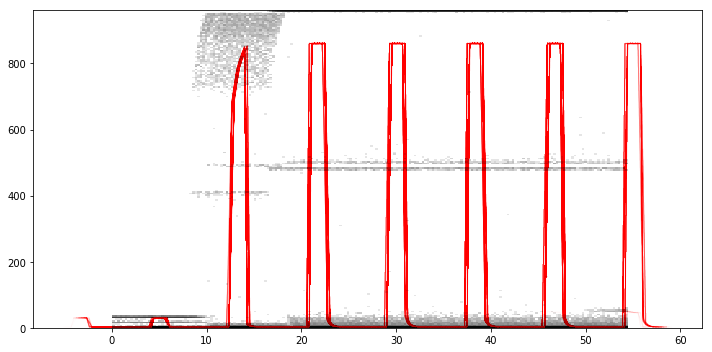

In [54]:
x = dd.TrialTime # + dd.groupby('Trial').DisplayLatency.mean().mean()
y = dd.SensorBrightness
nsamples_per_trial = dd.groupby('Trial')['DisplayLatency'].agg(len).min()
H, xedges, yedges = np.histogram2d(x, y, bins=(nsamples_per_trial, 200))
H = H.T
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax2 = plt.subplots(figsize=(10,5))

ax2.imshow(H, interpolation='nearest', origin='low', cmap=my_cmap, aspect='auto', 
          extent=extent, norm=colors.LogNorm())
mean_latency = dd.groupby('Trial').DisplayLatency.mean().mean()
for trialnum, trial in dd.groupby('Trial'):
    ax2.plot(trial.TrialTransitionTime + mean_latency, trial.SensorBrightness, c=color, linewidth=1, alpha=.01)

plt.tight_layout()

## Latencies

In [ ]:
for sess_id in range(0, 28):
    session = dfp.iloc[sess_id].name
    dl = latencies[latencies['Session'] == session]

    fig, axes= plt.subplots(1, 2, figsize=(10, 5), gridspec_kw = {'width_ratios': [2, 1]}, sharey=True)
    (ax1, ax2) = axes

    ax1.plot(dl['Trial'], dl['DisplayLatency'], c='k', linewidth=.5);
    sns.distplot(dl['DisplayLatency'].dropna().values, hist=False, color="k", kde_kws={"linewidth": 3, "alpha": 1}, 
                 ax=axes[1], vertical=True);
    ax1.set(ylabel='Time from trial onset (ms)')
    ax1.set_xlabel('Trial number')

    fig.tight_layout(w_pad=0)
    fig.suptitle(session, y=1.02)
    fig;
    plt.savefig(path_fig + session + '_' + str(sess_id) + '_latencies.png')

---

## Aggregation analysis

In [ ]:
df_data = df_data_all.copy()
df_params = df_params_all.copy()

Merge the df_data_all with df_latency

In [ ]:
df_data_latency = pd.merge(df_data_all, df_latency, on=['Session', 'Trial'])
df_data_latency.tail()

Merge the df_params_all with df_latency

In [ ]:
df_params_latency = pd.merge(df_latency, df_params, on='Session')
df_params_latency.head()

Merge the df_data_latency with the df_params_all

In [ ]:
df = pd.merge(df_data_latency, df_params, on='Session')
df = df.rename(columns={'Time_x': 'Time', 'Time_y': 'Exp_Time'})
df.head()

---

Now we have different dataframes available, we can chose one and perform out analysis on it

In [ ]:
df = df_params_latency.copy()

In [ ]:
grp = df.groupby('Session')
dff = grp.get_group(20)
sns.distplot(dff.Latency)

In [ ]:
sns.catplot(x='Rate', y='Latency', hue='Session', kind="point", data=df)

## Same monitor, different parameters

In [ ]:
df = df_params_latency.copy()

In [ ]:
for ind, (name, dff) in enumerate(df.groupby('Monitors')):
    print(ind, name)

In [ ]:
grp = df.groupby('Monitors')
name = list(grp)[0][0]
df_mon = grp.get_group(name)
df_mon.head()

In [ ]:
for name, df_mon in df.groupby('Monitors'):
    print('Monitor:', name)
    try:
        for (h, w), df_res in df_mon.groupby(['Height','Width']):
            sns.distplot(df_res.Latency / 1000, hist=False, label=h + ' x ' + w)
        
        plt.title(name)
        plt.xlabel('Latency (ms)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig('C:/Users/Mohammad Bashiri/Desktop/single-mon' + name + '.png')
        plt.show()
    except ValueError:
        pass

In [ ]:
for name, df_mon in df.groupby('Monitors'):
    print('Monitor:', name)
    try:
        sns.catplot(x='Width', y='Latency', hue='Rate', col='Height', kind="point", data=df_mon)
        
#         plt.title(name)
#         plt.legend()
#         plt.savefig('C:/Users/Mohammad Bashiri/Desktop/single-mon' + name + '.png')
        plt.show()
    except ValueError:
        pass

In [ ]:
sns.catplot(x='Width', y='Latency', hue='Rate', col='Height', kind="box", data=df_mon)

## Same paramet different monitor

In [ ]:
df = df_params_latency.copy()

In [ ]:
grp = df.groupby(['Height', 'Width'])

In [ ]:
for name, dff in grp:
    print(name, dff.Monitors.unique())
    sns.catplot(x='Rate', y='Latency', hue='Depth', kind='point', data=dff)